### Make environment

In [46]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

import numpy as np

from src.utils.constants import ParamTuple
from src.utils.make_environment import (
    transition_matrix,
    Environment,
    insert_walls_into_T,
)

from src.utils.visualization import plot_environment

height = 7
width = 7
rewards = np.zeros((height, width))
wall_states = np.zeros((height, width))

rewards[6,0] = 1
rewards[6,6] = 3

# rewards[5,0] = -1
# rewards[4,0] = -1

rewards = rewards.flatten()

goal_states = np.where(rewards > 0)[0]

wall_states[2,0] = 1
# wall_states[4,1] = 1

wall_states = wall_states.flatten()
wall_states = np.where(wall_states > 0)[0]

agent_p = 0.9
agent_gamma = 0.7
p_true=1

true_params = ParamTuple(agent_p, agent_gamma, rewards)

wall_states = [14]

T_true = transition_matrix(height, width, p=p_true, absorbing_states=goal_states)
T_True = insert_walls_into_T(T=T_true, wall_indices=wall_states)

### Value Iteration to find fixed point.

In [2]:
import torch

def soft_q_iteration_torch(
    R: torch.Tensor,  # R is a one-dimensional tensor with shape (n_states,)
    T_agent: torch.Tensor,
    gamma: float,
    beta: float,  # Inverse temperature parameter for the softmax function
    tol: float = 1e-6,
) -> torch.Tensor:
    n_states, n_actions, _ = T_agent.shape
    V = torch.zeros(n_states)
    Q = torch.zeros((n_states, n_actions))
    policy = torch.zeros((n_states, n_actions))

    while True:
        for s in range(n_states):
            for a in range(n_actions):
                # Calculate the Q-value for action a in state s
                Q[s, a] = R[s] + gamma * torch.dot(T_agent[s, a], V)

        # Apply softmax to get a probabilistic policy
        # max_Q = torch.max(Q, axis=1, keepdim=True)[0]
        exp_Q = torch.exp(beta * (Q))  # Subtract max_Q for numerical stability
        # exp_Q = torch.exp(beta * (Q - max_Q))  # Subtract max_Q for numerical stability

        policy = exp_Q / torch.sum(exp_Q, axis=1, keepdim=True)

        # Calculate the value function V using the probabilistic policy
        V_new = torch.sum(policy * Q, axis=1)

        # Check for convergence
        if torch.max(torch.abs(V - V_new)) < tol:
            break

        V = V_new

    return Q, V, policy

In [18]:
Q_star, V_star, policy_star = soft_q_iteration_torch(R = torch.tensor(rewards, dtype=torch.float32), T_agent = torch.tensor(T_True, dtype=torch.float32), gamma = agent_gamma, beta = 1)

### Soft Bellman Operator for fixed point.

Questions:

In [5]:
R = torch.tensor(rewards, dtype=torch.float32)

In [24]:
def soft_bellman_update_V(R, gamma, T, V):
    return torch.log(torch.sum(torch.exp(torch.matmul(T, R+gamma*V)), axis=1))

def soft_bellman_FP_V(R, gamma, T, V):
    return soft_bellman_update_V(R, gamma, T, V) - V

def soft_V_iteration_torch(R, gamma, T, V_init=None, tol=1e-6):
    if V_init is None:
        V_init = torch.zeros(49)

    V = V_init
    
    while True:
        V_new = soft_bellman_update_V(R, gamma,T, V)
        if torch.max(torch.abs(V - V_new)) < tol:
            break
        V = V_new
    return V

V_star_parallel = soft_V_iteration_torch(R, agent_gamma, torch.tensor(T_True, dtype=torch.float32), V_init=None, tol=1e-6)


In [4]:
def soft_bellman_update(R, gamma, T, Q):
    return R + gamma * torch.matmul(T, torch.log(torch.sum(torch.exp(Q), axis=1)))

def soft_bellman_fp(R, gamma, T, Q):
    return soft_bellman_update(R, gamma, T, Q) - Q

def soft_q_iteration_torch(R, gamma, T, Q_init=None, tol=1e-6):
    if Q_init is None:
        Q_init = torch.zeros(R.shape[0], 4)

    Q = Q_init
    
    while True:
        Q_new = soft_bellman_update(R, gamma,T, Q)
        if torch.max(torch.abs(Q - Q_new)) < tol:
            break
        Q = Q_new
    return Q

In [35]:
R = torch.tensor(rewards, dtype=torch.float32, requires_grad=True)
R_stretched = R.unsqueeze(1).repeat(1,4) # Stretch R to match the shape of Q, e.g. we switch from R(s) to R(s,a).

Q_star = soft_q_iteration_torch(R_stretched, agent_gamma, torch.tensor(T_True, dtype=torch.float32), Q_init=None, tol=1e-6)

beta = 1
exp_Q = torch.exp(beta * (Q_star))  # Subtract max_Q for numerical stability

policy = exp_Q / torch.sum(exp_Q, axis=1, keepdim=True)

# Calculate the value function V using the probabilistic policy
V_new = torch.sum(policy * Q_star, axis=1)

Calculate Derivative of Value Function.

In [27]:
R_grad = torch.autograd.Variable(R, requires_grad=True)
T_torch = torch.tensor(T_True, dtype=torch.float32)
T_grad = torch.autograd.Variable(T_torch, requires_grad=True)
V_star_grad = torch.autograd.Variable(V_star_parallel, requires_grad=True)

psi = soft_bellman_FP_V(R = R_grad, gamma=agent_gamma, T=T_grad, V = V_star_grad)

psi.backward(torch.ones_like(psi))

In [35]:
jacobian = torch.autograd.functional.jacobian(func=soft_bellman_FP_V, inputs=(R_grad, torch.tensor(agent_gamma, dtype = torch.float32), T_grad, V_star_grad))

In [50]:
df_dw_inv.shape

torch.Size([49, 49])

In [49]:
T_grad.grad.shape

torch.Size([49, 4, 49])

In [47]:
df_dw = jacobian[3]
df_dw_inv = torch.inverse(df_dw)

R_grad_out = - torch.matmul(df_dw_inv, R_grad.grad)
T_grad_out = - torch.matmul(df_dw_inv, T_grad.grad)

R_grad_out

RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [49, 49] but got: [49, 4].

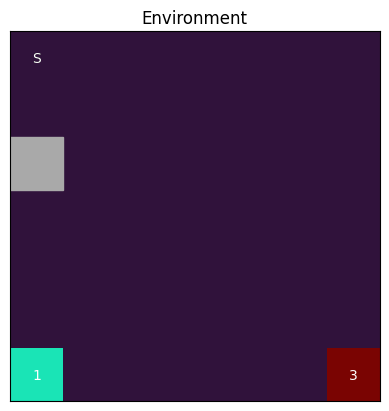

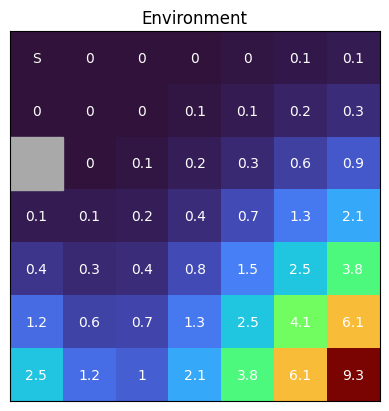

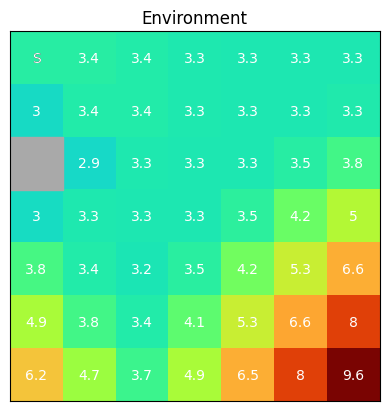

In [54]:
plot_environment(reward_function=R.detach().numpy().reshape(height, width), wall_states=wall_states)
plot_environment(reward_function=V_star.detach().numpy().reshape(height, width), wall_states=wall_states)
plot_environment(reward_function=R_grad_out.detach().numpy().reshape(height, width), wall_states=wall_states)